In [1]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [2]:
env = BlackjackEnv()

In [12]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def pi(observation):
        S=observation
        #Initialise all the actions pi chooses to be epsilon/|A(S)|
        probs=np.ones(nA)*epsilon/nA
        #calculate best action
        A_star=np.argmax(Q[S])
        #update according to first visit MC constrol
        probs[A_star]+=(1-epsilon)
        return probs
    
    return pi

In [13]:
def generate_sequence(policy):
    Episode=[]
    notEndOfEpisode=True
    S=env.reset()
    while notEndOfEpisode:
        pi = policy(S)
        A = np.random.choice(np.arange(len(pi)), p=pi)
        S_next, R, Criteria, _ = env.step(A)
        Episode.append((S,A,R))
        if notEndOfEpisode==Criteria:
            notEndOfEpisode=False
        S=S_next
    return Episode

In [14]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    # loop over all episodes
    for j in range(0,num_episodes):
        
        #generate sequence for episode
        sequence=generate_sequence(policy)
        
        Unique_states_actions = set([(x[0],x[1]) for x in sequence])
        for state,action in Unique_states_actions:
            sa_pair = (state, action)
            # first visit of state S in sequence
            first_visit,i=0,0
            for x in enumerate(sequence):
                if x[0]==state and x[1]==action:
                    first_visit=i
                i+=1
                
            #Sum of discounted returns
            G=[]
            i=1
            for x in enumerate(sequence[first_visit:]):
                G.append(x[1][2]*(discount_factor**i))
                i+=1
            G = sum(G)
            
            # Calculate average return for this state over all sampled episodes
            returns_sum[sa_pair] += G
            returns_count[sa_pair] += 1.0
            Q[state][action] = returns_sum[sa_pair] / returns_count[sa_pair]
    
    return Q, policy

In [15]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)

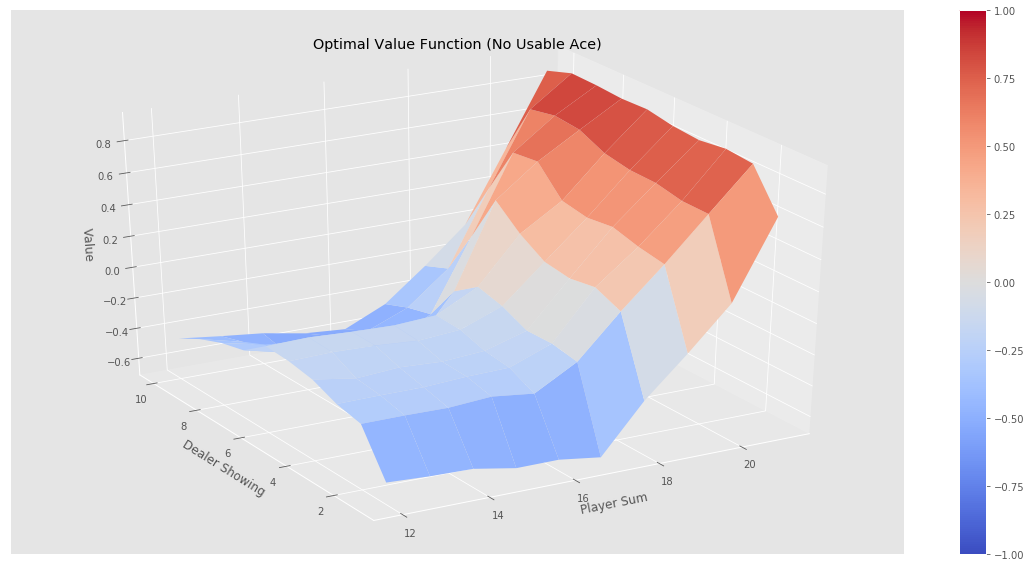

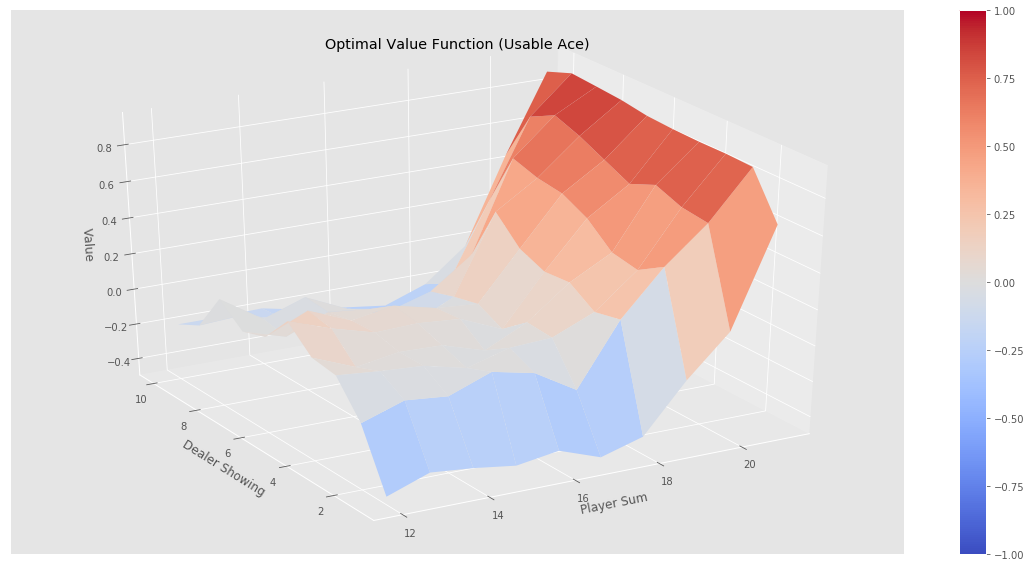

In [16]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")